This notebook is part of the AI Engineer Track Challenge for Digital Product School. Please see the repository at https://github.com/diksha-shrivastava13/Traffic-Accidents-Model
This notebook contains the EDA and Data Preprocessing steps for the task.

## The Necessary Imports, Loading Data and W&B Configuration

In [1]:
!pip install chart-studio
!pip install googletrans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15716 sha256=3e15304b7c31e96e235881355eb5216f0f46217b6b38bc7c158b6bbc4161fcb6
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting 

In [2]:
!pip install --upgrade googletrans==4.0.0-rc1
!pip install translate

  Preparing metadata (setup.py) ... - \ | done
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=79247ea3d48aadf3e529f35e53c5018ae62258b52e60804cd260bd549c91d52f
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.0.0
    Uninstalling googletrans-3.0.0:
      Successfully uninstalled googletrans-3.0.0


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# Plotly
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

# NumPy and SciPy
from numpy.random import normal, seed
from scipy.stats import norm

# Scikit-Learn
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error

# XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Meta Prophet
from prophet import Prophet

Now, we load the data. The "Monatszahlen Verkehrsunfälle" dataset has been taken from [München Open Data Portal](https://opendata.muenchen.de/dataset/monatszahlen-verkehrsunfaelle/resource/40094bd6-f82d-4979-949b-26c8dc00b9a7), detailing monthly figures for traffic accidents.

In [4]:
df = pd.read_csv("/kaggle/input/monthly-figures-for-traffic-accidents/monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv")
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


In [5]:
rows, columns = df.shape
print(f'There are {rows} rows and {columns} columns in the dataset')

There are 2016 rows and 9 columns in the dataset


For convenience and easier manipulation of data, I'm gonna translate everything to English (I'm sorry). I'm gonna use google translator for this, I do not think it's a good model but convenient for my use case right now since I've a very small number of features to work with. 

In [6]:
# function to translate from German to English
from translate import Translator
def translate_strings_to_english(string_list, source_lang='de', target_lang='en'):
    """
    Translate a list of strings from the source language to the target language.

    Parameters:
    - string_list: list of strings
    - source_lang: str, default='de', source language code
    - target_lang: str, default='en', target language code

    Returns:
    - Translated list of strings
    """
    translator = Translator(to_lang=target_lang, from_lang=source_lang)
    translated_strings = [translator.translate(s) for s in string_list]
    return translated_strings

def translate_columns_to_english(df, source_lang='de', target_lang='en'):
    """
    Translate DataFrame column names from the source language to the target language.

    Parameters:
    - df: pandas DataFrame
    - source_lang: str, default='de', source language code
    - target_lang: str, default='en', target language code

    Returns:
    - None (updates DataFrame in-place)
    """
    translated_columns = translate_strings_to_english(df.columns, source_lang=source_lang, target_lang=target_lang)
    df.columns = translated_columns
    
def translate_categorical_values_to_english(df, source_lang='de', target_lang='en'):
    """
    Translate unique values in categorical columns of a DataFrame from the source language to the target language.

    Parameters:
    - df: pandas DataFrame
    - source_lang: str, default='de', source language code
    - target_lang: str, default='en', target language code

    Returns:
    - None (updates DataFrame in-place)
    """
    for col in df.select_dtypes(include='object').columns:
        unique_values = df[col].unique()
        translated_values = translate_strings_to_english(unique_values, source_lang=source_lang, target_lang=target_lang)
        translation_dict = dict(zip(unique_values, translated_values))
        df[col] = df[col].map(translation_dict)

In [7]:
df.columns

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')

In [8]:
translate_columns_to_english(df)
df.head()

,Month Count,CHARACTERISTIC,YEAR,MONTH,VALUE,PREVIOUS YEAR'S VALUE,VERAEND_VORMONAT_PROZENT,VERAEND_PREVIOUS YEAR'S MONTH_PERCENT,TWELVE_MONTHS_MEAN
0,Alkoholunfälle,insgesamt,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2023,202305,NaN,NaN,NaN,NaN,NaN


In [9]:
df.columns

Index(['Month Count', 'CHARACTERISTIC', 'YEAR', 'MONTH', 'VALUE',
       'PREVIOUS YEAR'S VALUE', 'VERAEND_VORMONAT_PROZENT',
       'VERAEND_PREVIOUS YEAR'S MONTH_PERCENT', 'TWELVE_MONTHS_MEAN'],
      dtype='object')

Google translate, yet again, doesn't work well.

In [10]:
# demonstration of unique values of each categorical feature
for col in df.select_dtypes(include='object').columns:
    unique_values = df[col].unique()
    print(f'Column Name: {col} | {unique_values}')

Column Name: Month Count | ['Alkoholunfälle' 'Fluchtunfälle' 'Verkehrsunfälle']
Column Name: CHARACTERISTIC | ['insgesamt' 'Verletzte und Getötete' 'mit Personenschäden']


In [11]:
translate_categorical_values_to_english(df)

In [12]:
for col in df.select_dtypes(include='object').columns:
    unique_values = df[col].unique()
    print(f'Column Name: {col} | {unique_values}')

Column Name: Month Count | ['Alcohol Accidents' 'Escape accidents' 'Accidents, Traffic']
Column Name: CHARACTERISTIC | ['total' 'Injured and killed' 'with personal injury']


In [13]:
# Manually fixing the two columns in the dataframe
df.rename(columns={
    'VERAEND_VORMONAT_PROZENT': 'Change Previous Month Percentage',
    "VERAEND_PREVIOUS YEAR'S MONTH_PERCENT": "Change Previous Year's Month",
}, inplace=True)

In [14]:
df.head()

,Month Count,CHARACTERISTIC,YEAR,MONTH,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
0,Alcohol Accidents,total,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alcohol Accidents,total,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alcohol Accidents,total,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alcohol Accidents,total,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alcohol Accidents,total,2023,202305,NaN,NaN,NaN,NaN,NaN


Now, let's setup wandb integration. W&B artifacts can be used to store entire datasets and are very helpful for keeping track of different versions of the dataset and the models.

In [15]:
df.to_csv('translated_dataset.csv', index=False)

In [16]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api")
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# Configuring wandb artifacts
run = wandb.init(project="traffic-accidents", job_type="upload-dataset")
artifact = wandb.Artifact(name="dataset", type="dataset")
artifact.add_file("/kaggle/working/translated_dataset.csv")
wandb.log_artifact(artifact)
wandb.finish()

wandb: Currently logged in as: diksha-shrivastava13. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231202_082650-0wsqt8nz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hardy-paper-5
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/0wsqt8nz
wandb:                                                                                
wandb: 🚀 View run hardy-paper-5 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/0wsqt8nz
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231202_082650-0wsqt8nz/logs


Screenshot of the created dataset artifact
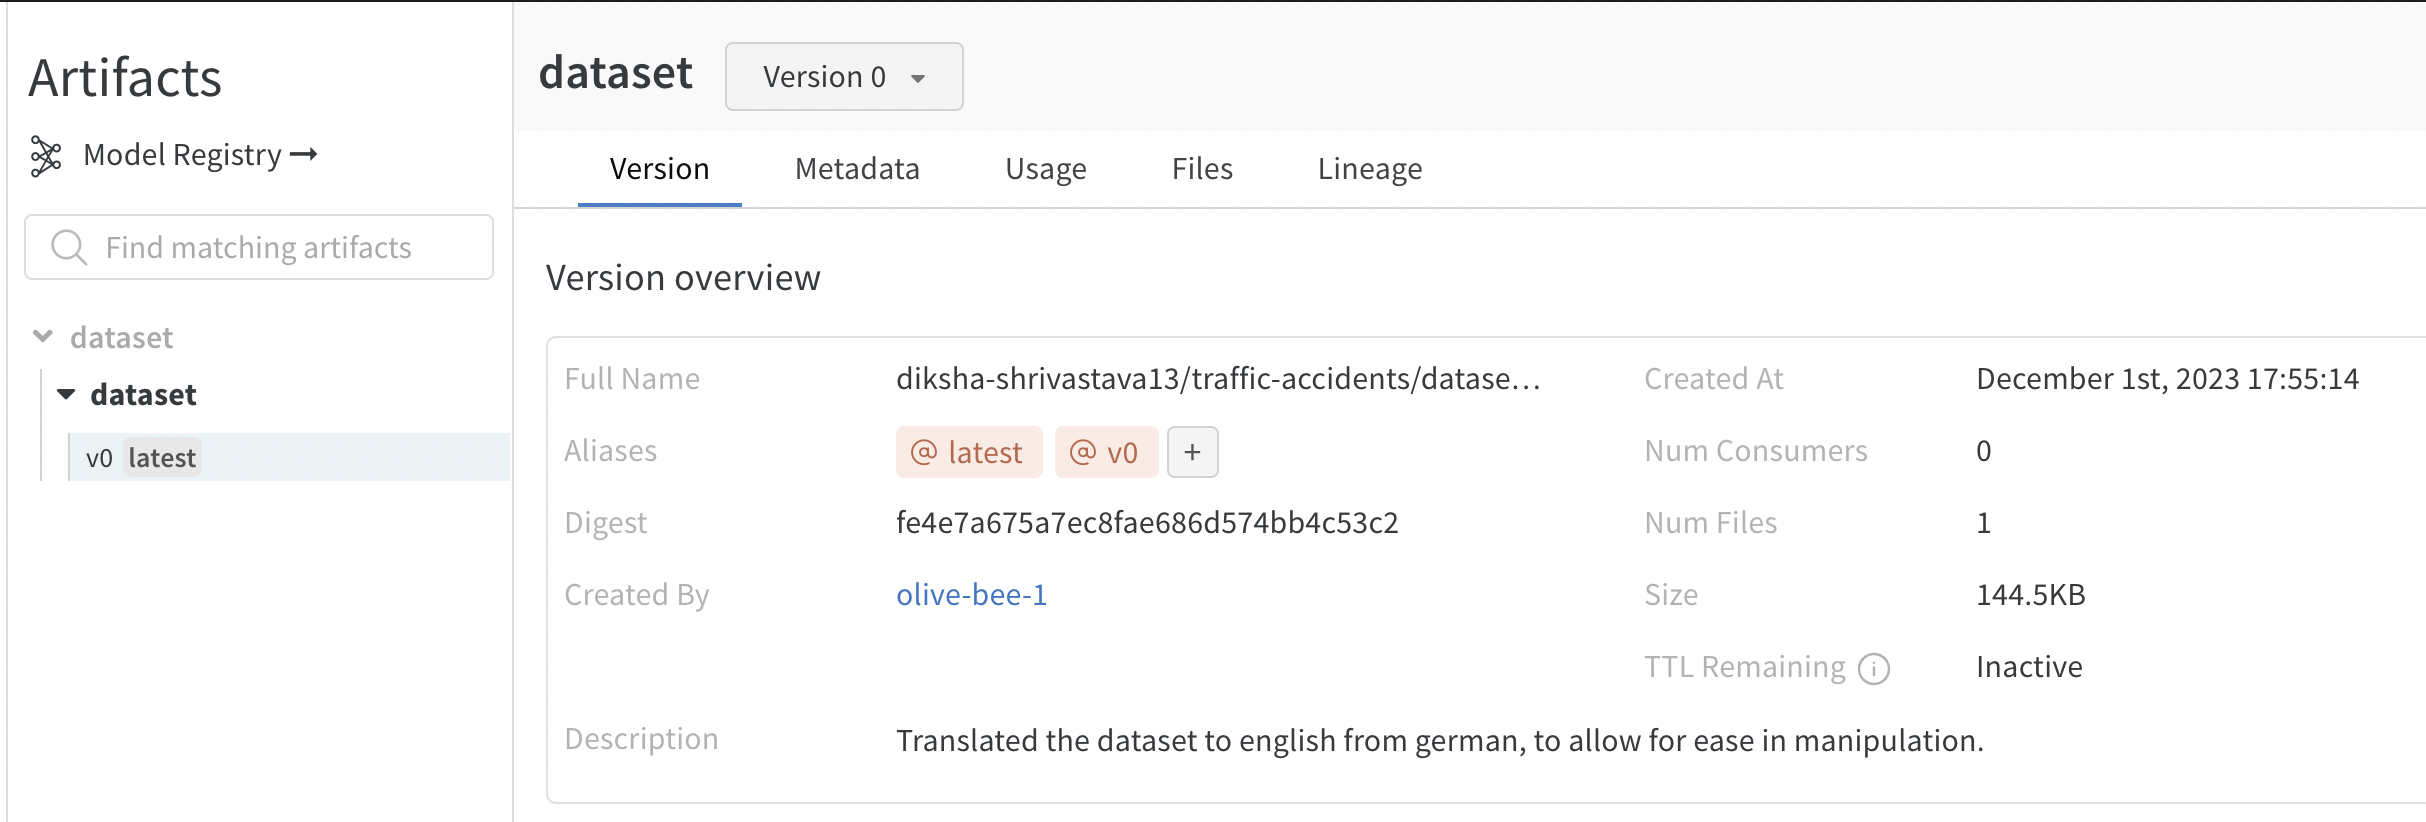

## Data Preprocessing and Visualisation

In [18]:
summary_df = df.drop(['YEAR', 'MONTH'], axis=1)
summary_df.describe().style.background_gradient(cmap="mako")

,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
count,1848.000000,1848.000000,1840.000000,1763.000000,1848.000000
mean,776.984848,776.984848,5.241538,1.897357,777.310065
std,1176.030443,1176.030443,40.926314,31.287810,1164.856446
min,0.000000,0.000000,-100.000000,-100.000000,12.000000
25%,38.000000,38.000000,-15.540000,-13.380000,40.000000
50%,358.500000,358.500000,0.000000,-1.130000,421.000000
75%,811.000000,811.000000,18.712500,11.485000,814.250000
max,4763.000000,4763.000000,600.000000,425.000000,3977.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Month Count                       2016 non-null   object 
 1   CHARACTERISTIC                    2016 non-null   object 
 2   YEAR                              2016 non-null   int64  
 3   MONTH                             2016 non-null   int64  
 4   VALUE                             1848 non-null   float64
 5   PREVIOUS YEAR'S VALUE             1848 non-null   float64
 6   Change Previous Month Percentage  1840 non-null   float64
 7   Change Previous Year's Month      1763 non-null   float64
 8   TWELVE_MONTHS_MEAN                1848 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 141.9+ KB


In [20]:
df.head()

,Month Count,CHARACTERISTIC,YEAR,MONTH,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
0,Alcohol Accidents,total,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alcohol Accidents,total,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alcohol Accidents,total,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alcohol Accidents,total,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alcohol Accidents,total,2023,202305,NaN,NaN,NaN,NaN,NaN


In [21]:
# dealing with the datetime data
df['MONTH'] = df['MONTH'] % 100

In [22]:
df.head()

,Month Count,CHARACTERISTIC,YEAR,MONTH,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
0,Alcohol Accidents,total,2023,1,NaN,NaN,NaN,NaN,NaN
1,Alcohol Accidents,total,2023,2,NaN,NaN,NaN,NaN,NaN
2,Alcohol Accidents,total,2023,3,NaN,NaN,NaN,NaN,NaN
3,Alcohol Accidents,total,2023,4,NaN,NaN,NaN,NaN,NaN
4,Alcohol Accidents,total,2023,5,NaN,NaN,NaN,NaN,NaN


In [23]:
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)

In [24]:
df.head()

,Month Count,CHARACTERISTIC,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN,Date
0,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-01-01
1,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-02-01
2,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-03-01
3,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-04-01
4,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-05-01


In [25]:
# dropping values which come after 2020
df = df[df['Date'].dt.year <= 2020]

In [26]:
df['Month Count'] = df['Month Count'].replace({'Accidents, Traffic': 'Traffic Accidents'})

In [27]:
numerical_col = df.select_dtypes(exclude=np.object_).drop(columns=["Date"])
categorical_col = list(df.select_dtypes(exclude=np.number).drop(columns=["Date"]))

In [28]:
numerical_col.head()

,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
36,28.0,22.0,-20.00,27.27,37.0
37,40.0,28.0,42.86,42.86,38.0
38,27.0,34.0,-32.50,-20.59,37.0
39,26.0,36.0,-3.70,-27.78,36.0
40,40.0,39.0,53.85,2.56,36.0


In [29]:
categorical_col

['Month Count', 'CHARACTERISTIC']

In [30]:
df = pd.get_dummies(df, columns=categorical_col, dtype=int)

In [31]:
df.head()

,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
36,28.0,22.0,-20.00,27.27,37.0,2020-01-01,1,0,0,0,1,0
37,40.0,28.0,42.86,42.86,38.0,2020-02-01,1,0,0,0,1,0
38,27.0,34.0,-32.50,-20.59,37.0,2020-03-01,1,0,0,0,1,0
39,26.0,36.0,-3.70,-27.78,36.0,2020-04-01,1,0,0,0,1,0
40,40.0,39.0,53.85,2.56,36.0,2020-05-01,1,0,0,0,1,0


In [32]:
df.dtypes

VALUE                                         float64
PREVIOUS YEAR'S VALUE                         float64
Change Previous Month Percentage              float64
Change Previous Year's Month                  float64
TWELVE_MONTHS_MEAN                            float64
Date                                   datetime64[ns]
Month Count_Alcohol Accidents                   int64
Month Count_Escape accidents                    int64
Month Count_Traffic Accidents                   int64
CHARACTERISTIC_Injured and killed               int64
CHARACTERISTIC_total                            int64
CHARACTERISTIC_with personal injury             int64
dtype: object

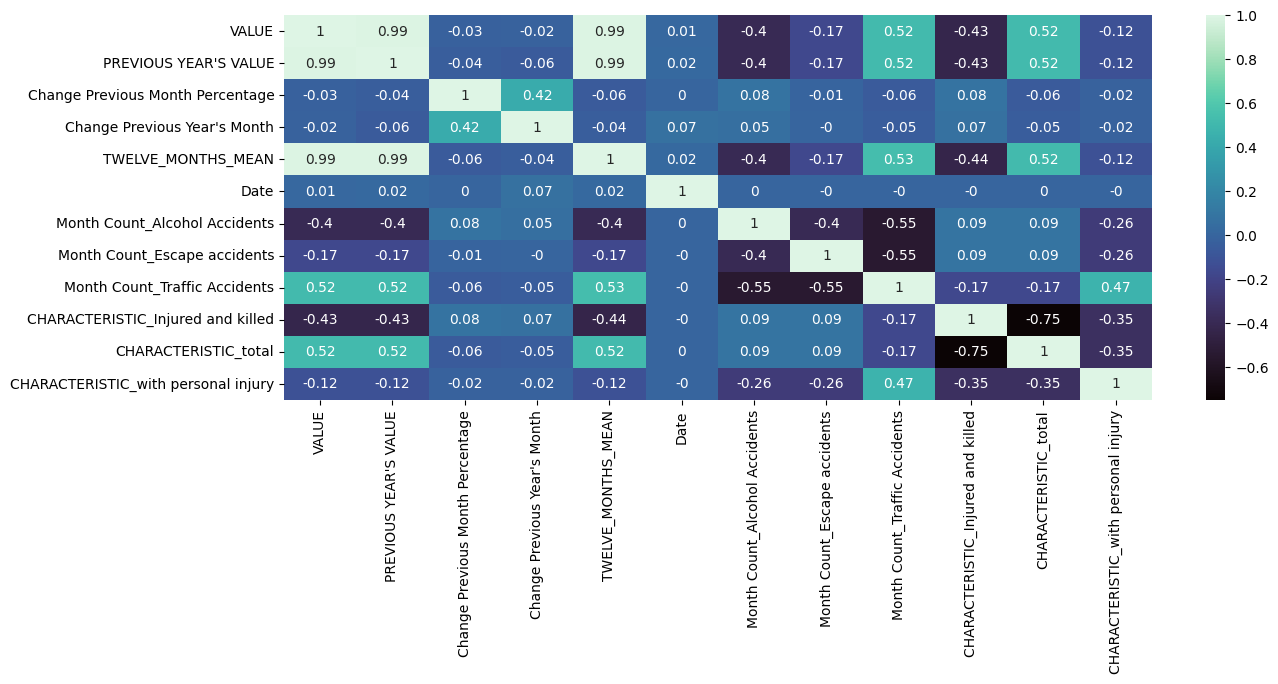

In [33]:
dataframe_corr = df.corr()
plt.figure(figsize=(14, 5))
sns.heatmap(round(dataframe_corr, 2), annot=True, cmap="mako")
plt.show()

In [34]:
df.head()

,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
36,28.0,22.0,-20.00,27.27,37.0,2020-01-01,1,0,0,0,1,0
37,40.0,28.0,42.86,42.86,38.0,2020-02-01,1,0,0,0,1,0
38,27.0,34.0,-32.50,-20.59,37.0,2020-03-01,1,0,0,0,1,0
39,26.0,36.0,-3.70,-27.78,36.0,2020-04-01,1,0,0,0,1,0
40,40.0,39.0,53.85,2.56,36.0,2020-05-01,1,0,0,0,1,0


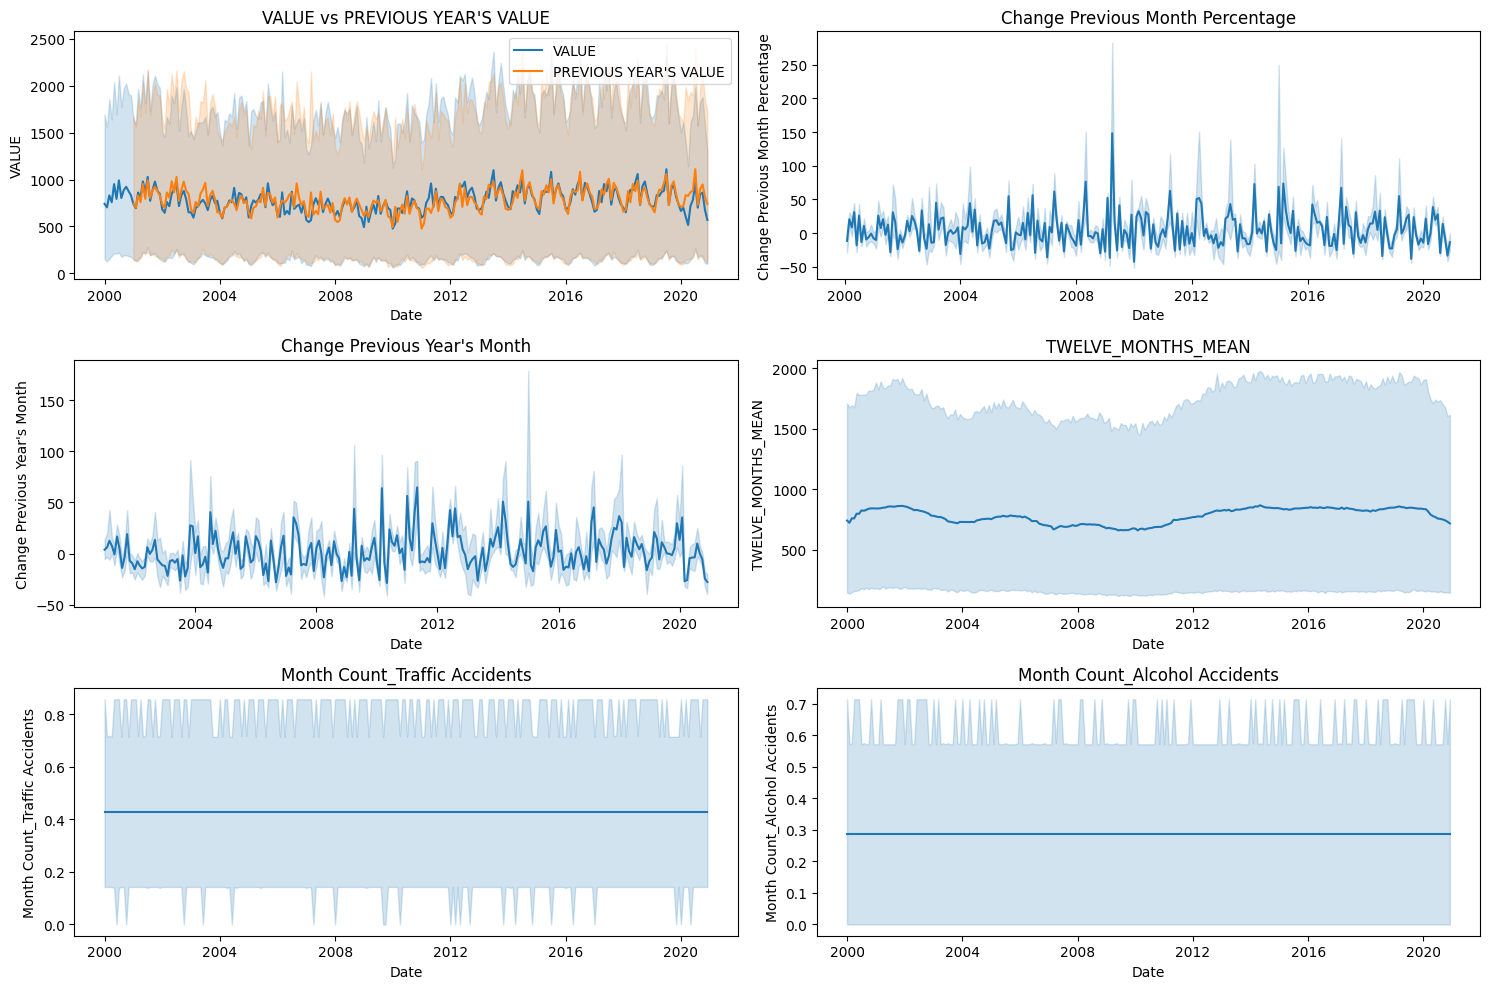

In [35]:
plt.figure(figsize=(15, 10))

# Line plot for 'VALUE' and 'PREVIOUS YEAR'S VALUE'
plt.subplot(3, 2, 1)
sns.lineplot(x=df["Date"], y=df['VALUE'], label='VALUE')
sns.lineplot(x=df["Date"], y=df["PREVIOUS YEAR'S VALUE"], label="PREVIOUS YEAR'S VALUE")
plt.title('VALUE vs PREVIOUS YEAR\'S VALUE')

# Line plot for 'Change Previous Month Percentage'
plt.subplot(3, 2, 2)
sns.lineplot(x=df["Date"], y=df['Change Previous Month Percentage'])
plt.title('Change Previous Month Percentage')

# Line plot for 'Change Previous Year's Month'
plt.subplot(3, 2, 3)
sns.lineplot(x=df["Date"], y=df["Change Previous Year's Month"])
plt.title('Change Previous Year\'s Month')

# Line plot for 'TWELVE_MONTHS_MEAN'
plt.subplot(3, 2, 4)
sns.lineplot(x=df["Date"], y=df['TWELVE_MONTHS_MEAN'])
plt.title('TWELVE_MONTHS_MEAN')

# Line plot for 'Month Count_Accidents, Traffic'
plt.subplot(3, 2, 5)
sns.lineplot(x=df["Date"], y=df['Month Count_Traffic Accidents'])
plt.title('Month Count_Traffic Accidents')

# Line plot for 'Month Count_Alcohol Accidents'
plt.subplot(3, 2, 6)
sns.lineplot(x=df["Date"], y=df['Month Count_Alcohol Accidents'])
plt.title('Month Count_Alcohol Accidents')

plt.tight_layout()
plt.show()

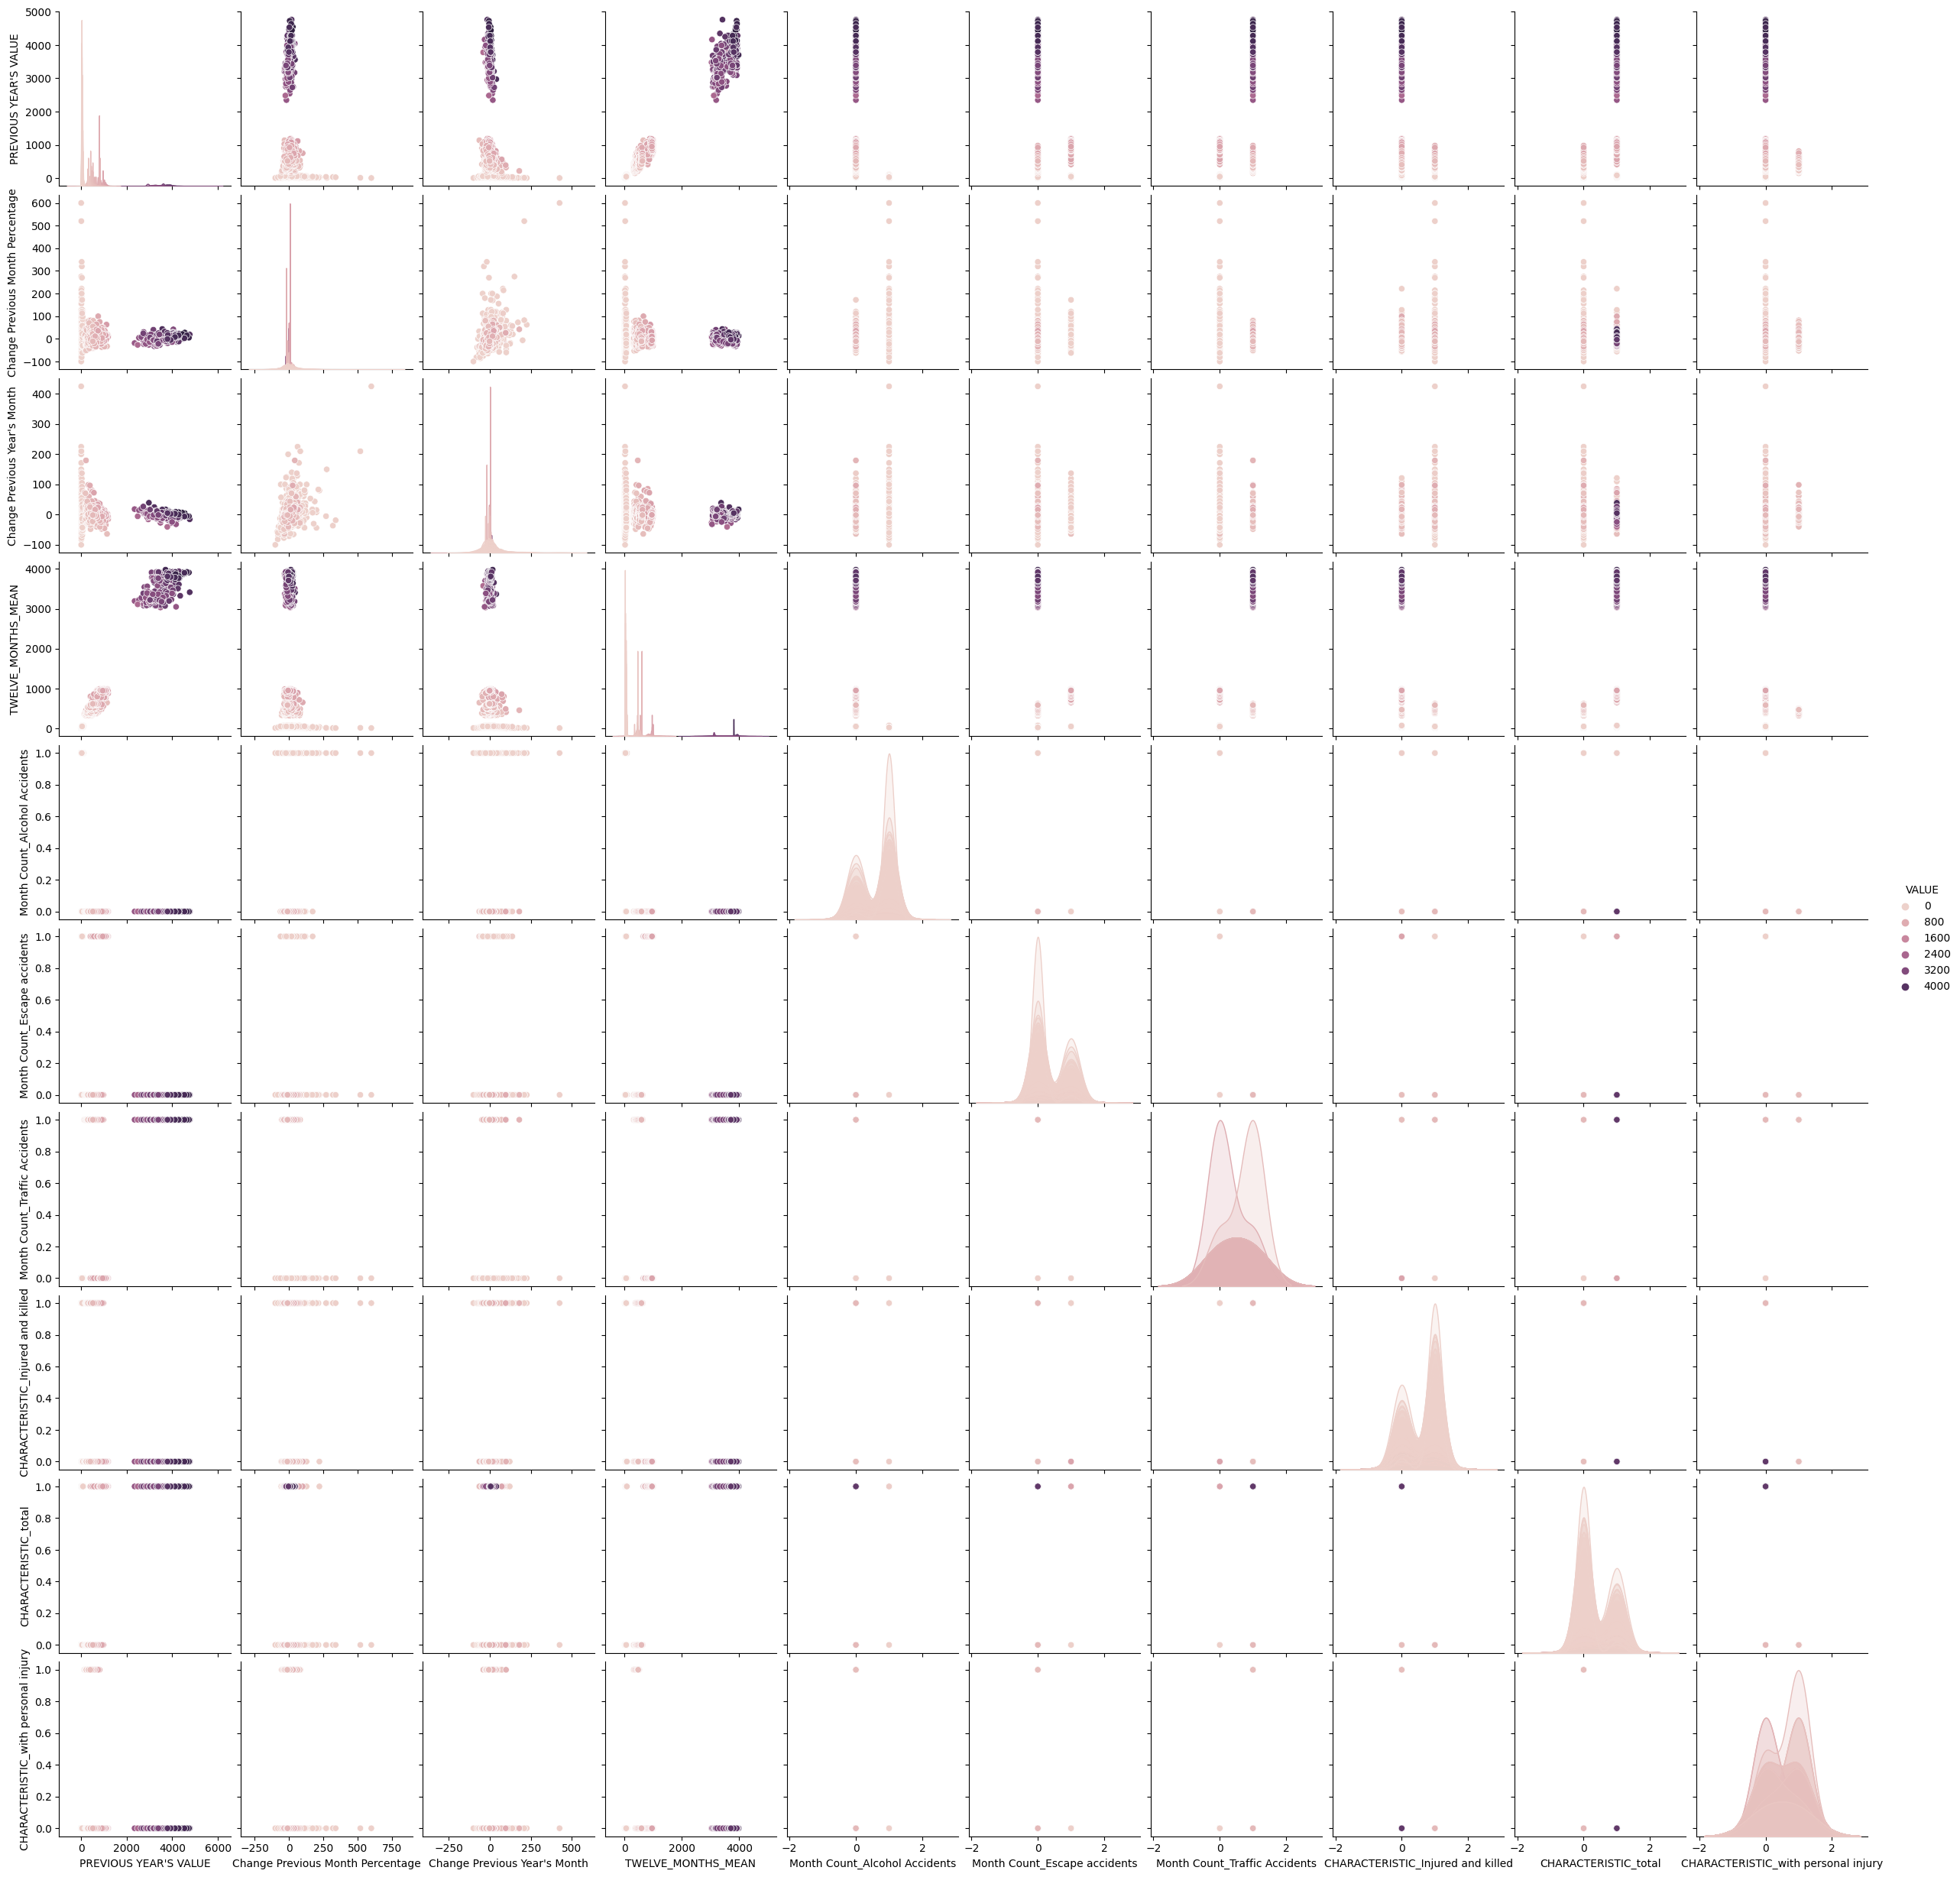

In [36]:
sns.pairplot(df, hue='VALUE')
plt.show()

In [37]:
df.columns

Index(['VALUE', 'PREVIOUS YEAR'S VALUE', 'Change Previous Month Percentage',
       'Change Previous Year's Month', 'TWELVE_MONTHS_MEAN', 'Date',
       'Month Count_Alcohol Accidents', 'Month Count_Escape accidents',
       'Month Count_Traffic Accidents', 'CHARACTERISTIC_Injured and killed',
       'CHARACTERISTIC_total', 'CHARACTERISTIC_with personal injury'],
      dtype='object')

In [38]:
# Dropping unneccessary columns
df = df.drop(columns=["PREVIOUS YEAR'S VALUE", 'Change Previous Month Percentage', "Change Previous Year's Month", 'TWELVE_MONTHS_MEAN'])
df.head()

,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
36,28.0,2020-01-01,1,0,0,0,1,0
37,40.0,2020-02-01,1,0,0,0,1,0
38,27.0,2020-03-01,1,0,0,0,1,0
39,26.0,2020-04-01,1,0,0,0,1,0
40,40.0,2020-05-01,1,0,0,0,1,0


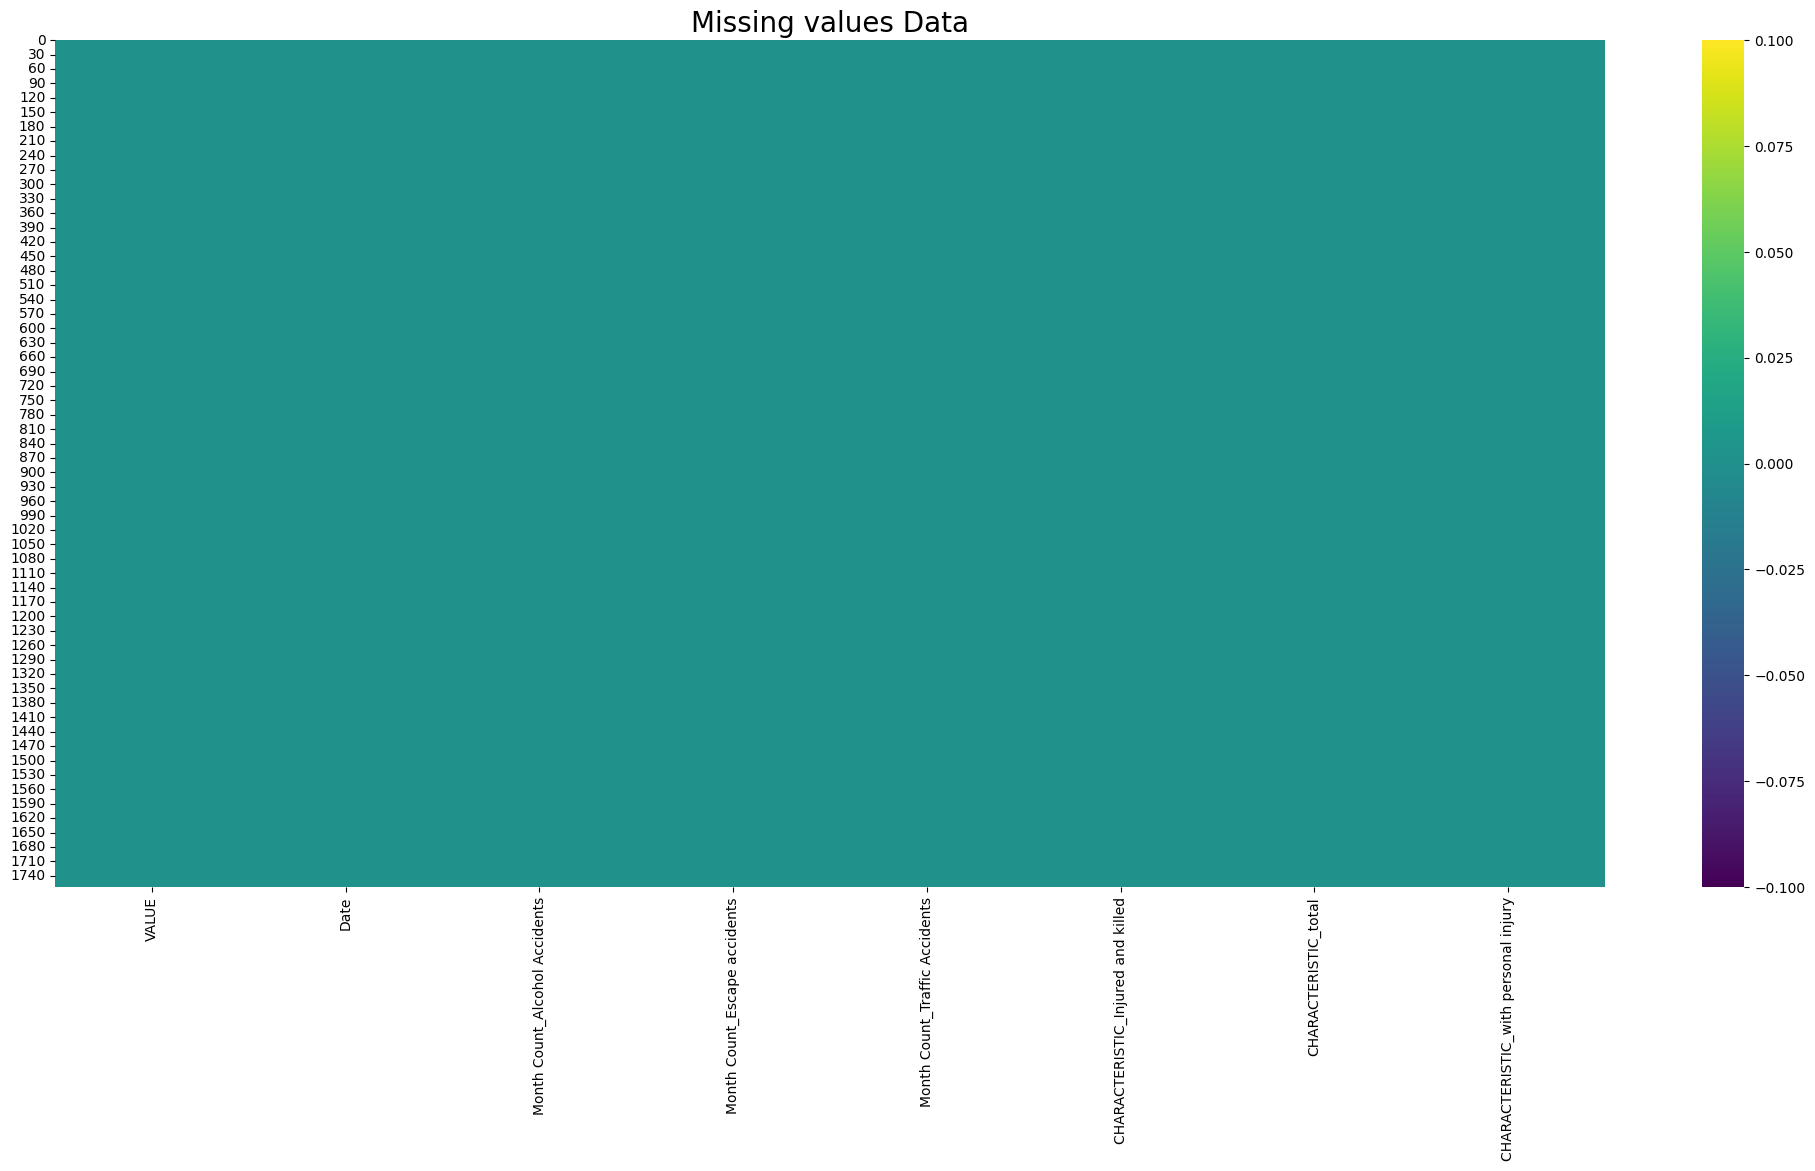

In [39]:
plt.figure(figsize = (25, 11))
sns.heatmap(df.isna().values, cmap="viridis", xticklabels=df.columns)
plt.title("Missing values Data", size=20)
plt.show()

In [40]:
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
df.to_csv("/kaggle/working/preprocessed_dataset.csv", index=False)
new_artifact = wandb.Artifact(name="preprocessed_dataset", type="dataset")
new_artifact.add_file("/kaggle/working/preprocessed_dataset.csv")
wandb.log_artifact(new_artifact)
wandb.finish()

wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231202_082953-3zw4nawe
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fallen-river-6
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/3zw4nawe
wandb:                                                                                
wandb: 🚀 View run fallen-river-6 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/3zw4nawe
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231202_082953-3zw4nawe/logs
